In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
%matplotlib inline

In [2]:
env = gym.make("LunarLander-v2")
env.reset()
env.render()

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("n_actions:", env.action_space.n)
n_actions = env.action_space.n

#Display
#plt.imshow(env.render('rgb_array'))


Observation space: Box(8,)
Action space: Discrete(4)
n_actions: 4


# Deep Crossentropy Method

* Intialize an MLP Policy with random weights
* Sample 100 sessions
* Pick elite sessions
* Fit the MLP Policy over elite sessions

In [3]:
#Create MLP agent/policy
from sklearn.neural_network import MLPClassifier
# from sklearn.externals import joblib
agent = MLPClassifier(hidden_layer_sizes=(20,20), activation = 'tanh',
                     warm_start=True,max_iter=1)
#Initialize policy
print([env.reset()]*n_actions, list(range(n_actions)))
agent.fit([env.reset()]*n_actions, list(range(n_actions)));
print([env.reset()]*n_actions)

[array([-0.00417595,  1.4076384 , -0.42300668, -0.14585546,  0.00484579,
        0.09581725,  0.        ,  0.        ], dtype=float32), array([-0.00417595,  1.4076384 , -0.42300668, -0.14585546,  0.00484579,
        0.09581725,  0.        ,  0.        ], dtype=float32), array([-0.00417595,  1.4076384 , -0.42300668, -0.14585546,  0.00484579,
        0.09581725,  0.        ,  0.        ], dtype=float32), array([-0.00417595,  1.4076384 , -0.42300668, -0.14585546,  0.00484579,
        0.09581725,  0.        ,  0.        ], dtype=float32)] [0, 1, 2, 3]
[array([ 0.00666485,  1.4167541 ,  0.6750573 ,  0.25927207, -0.00771606,
       -0.1529105 ,  0.        ,  0.        ], dtype=float32), array([ 0.00666485,  1.4167541 ,  0.6750573 ,  0.25927207, -0.00771606,
       -0.1529105 ,  0.        ,  0.        ], dtype=float32), array([ 0.00666485,  1.4167541 ,  0.6750573 ,  0.25927207, -0.00771606,
       -0.1529105 ,  0.        ,  0.        ], dtype=float32), array([ 0.00666485,  1.4167541 ,  0.6750

/home/otoshuki/anaconda3/envs/tf2-gpu/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [4]:
"""Comment these to use env.render()"""
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(111)
#Generate play sessions
def generate_session(t_max = 10000):
    states, actions = [], []
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        #Action probabilities in current state
        probs = agent.predict_proba([s])[0]
        #Select a random action with probs bias
        a = np.random.choice(n_actions, p = probs)
        new_s, r, done, info = env.step(a)
        
        #Record sessions
        states.append(s)
        actions.append(a)
        total_reward += r
#         ax.clear()
#         ax.imshow(env.render('rgb_array'))
#         fig.canvas.draw()
        #This one ia faster
        #env.render()
        #Set the new state
        s = new_s
        if done: break
    return states, actions, total_reward     
        

In [5]:
#Select Elite Sessions
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    #Set threshold based on percentile
    reward_threshold = np.percentile(rewards_batch,percentile)
    elite_states = []
    elite_actions = []
    #For each session
    for session in range(len(rewards_batch)):
        #Select sessions with rewards>=threshold
        if rewards_batch[session] >= reward_threshold:
            for state in range(len(states_batch[session])):
                elite_states.append(states_batch[session][state])
                elite_actions.append(actions_batch[session][state])
    return elite_states, elite_actions

In [6]:
from IPython.display import clear_output
#To display current progress
def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = 17.537, threshold=36.098


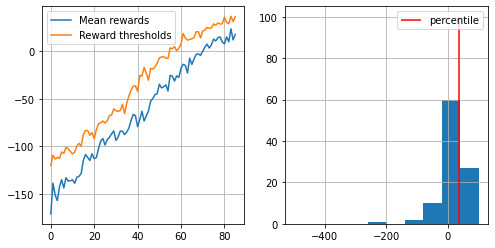

86


In [ ]:
#Train
n_sessions = 100
percentile = 70
log = []
filename = 'saved_weight.sav'

for iter in range(100):
    print(iter)
    sessions = [generate_session() for sess in range(n_sessions)]
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile)
    #Fit agent
    agent.fit(elite_states, elite_actions)
#     joblib.dump(agent, filename)
    #show_progress(batch_rewards, log, percentile, reward_range=[0,np.max(-1*batch_rewards)])
    show_progress(batch_rewards, log, percentile, reward_range=[-500,np.max(batch_rewards)])
    if np.mean(batch_rewards)> 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")

In [ ]:
#Load Models
result = agent.score(elite_states, elite_actions)
print(result)

In [ ]:
#Display final results
fig = plt.figure()
ax = fig.add_subplot(111)
total_reward = 0
s = env.reset()
#env.render()
for t in range(10000):
    #Action probabilities in current state
    probs = agent.predict_proba([s])[0]
    #Select a random action with probs bias
    a = np.random.choice(n_actions, p = probs)
    new_s, r, done, info = env.step(a)
    total_reward += r
    ax.clear()
    ax.imshow(env.render('rgb_array'))
    fig.canvas.draw()
    #Set the new state
    s = new_s
    if done: break
print(total_reward)